# PyTorch GAN / DCGAN

We can use PyTorch to implement generative adversarial networks.

In [154]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import requests
import copy
from io import BytesIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset

In [2]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
                               
train_set = datasets.MNIST(root=".", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

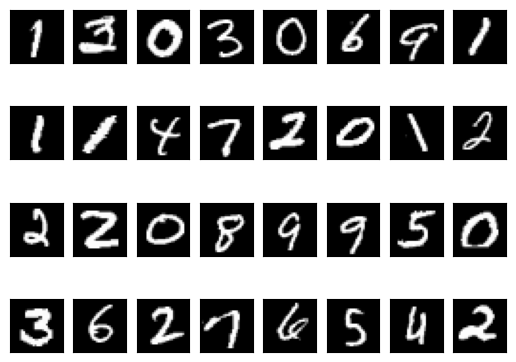

In [3]:
samples, labels = next(iter(train_loader))

for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

## Define discriminator and generator models

In [167]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # We don't use Conv layers here but we vectorize our inputs
            nn.Linear(784, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
            #nn.Sigmoid(), #not using sigmoid activation togheter with BCEWithLogitsLoss instead of BCELoss seems to prevent Discriminator loss going to zero for longer
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), # We use the Tanh() activation fucntion so that our outputs lie between -1 and 1
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output



discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

## Training

In [174]:
def train_gan(discriminator, generator, train_loader, epochs, gen_optimizer, disc_optimizer, loss_function, batch_size):
    
    for epoch in tqdm(range(epochs), desc="Total train progress", position=0):
        for n, (samples, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}', position=1, leave=False), 0):
            # Get data for training the discriminator
            real_samples = samples.to(device=device)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            generated_samples = generator(latent_space_samples)
            
            generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

            # Training the discriminator
            discriminator.zero_grad()

            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            disc_optimizer.step()

            # Data for training the generator
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            gen_optimizer.step()

        print(f"Epoch: {epoch}, Generator Loss: {loss_generator}, Discriminator Loss: {loss_discriminator}")

In [175]:
lr = 0.0001
epochs = 50
loss_function = nn.BCEWithLogitsLoss() #nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr*0.1)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [176]:
train_gan(discriminator, generator, train_loader, epochs, optimizer_generator, optimizer_discriminator, loss_function, batch_size)

Total train progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 0, Generator Loss: 4.226430416107178, Discriminator Loss: 0.20370259881019592


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1, Generator Loss: 3.477074146270752, Discriminator Loss: 0.16904506087303162


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2, Generator Loss: 3.130910873413086, Discriminator Loss: 0.15836003422737122


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3, Generator Loss: 4.216435432434082, Discriminator Loss: 0.06609857082366943


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4, Generator Loss: 3.659245729446411, Discriminator Loss: 0.12565001845359802


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5, Generator Loss: 3.1823558807373047, Discriminator Loss: 0.30492454767227173


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6, Generator Loss: 3.855133533477783, Discriminator Loss: 0.2123139649629593


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7, Generator Loss: 3.9985759258270264, Discriminator Loss: 0.04293099790811539


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8, Generator Loss: 3.753877639770508, Discriminator Loss: 0.06567172706127167


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9, Generator Loss: 3.1272287368774414, Discriminator Loss: 0.16324996948242188


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10, Generator Loss: 3.955035924911499, Discriminator Loss: 0.09864919632673264


Epoch 12:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 11, Generator Loss: 4.088630199432373, Discriminator Loss: 0.0952325239777565


Epoch 13:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 12, Generator Loss: 2.6965291500091553, Discriminator Loss: 0.42181771993637085


Epoch 14:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 13, Generator Loss: 2.439220428466797, Discriminator Loss: 0.4069351851940155


Epoch 15:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 14, Generator Loss: 2.2550039291381836, Discriminator Loss: 0.29505565762519836


Epoch 16:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 15, Generator Loss: 1.767413854598999, Discriminator Loss: 0.3666309118270874


Epoch 17:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 16, Generator Loss: 1.6883082389831543, Discriminator Loss: 0.3974469304084778


Epoch 18:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 17, Generator Loss: 1.413365125656128, Discriminator Loss: 0.38789865374565125


Epoch 19:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 18, Generator Loss: 1.2669587135314941, Discriminator Loss: 0.5833755731582642


Epoch 20:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 19, Generator Loss: 1.4430906772613525, Discriminator Loss: 0.5310730338096619


Epoch 21:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 20, Generator Loss: 1.215683937072754, Discriminator Loss: 0.5167640447616577


Epoch 22:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 21, Generator Loss: 1.1132723093032837, Discriminator Loss: 0.4873755872249603


Epoch 23:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 22, Generator Loss: 1.0446275472640991, Discriminator Loss: 0.5180826187133789


Epoch 24:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 23, Generator Loss: 1.1870288848876953, Discriminator Loss: 0.7100757956504822


Epoch 25:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 24, Generator Loss: 1.0860710144042969, Discriminator Loss: 0.5295361280441284


Epoch 26:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 25, Generator Loss: 0.8500919342041016, Discriminator Loss: 0.5193599462509155


Epoch 27:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 26, Generator Loss: 0.9495144486427307, Discriminator Loss: 0.6420117616653442


Epoch 28:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 27, Generator Loss: 1.0569329261779785, Discriminator Loss: 0.5402323007583618


Epoch 29:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 28, Generator Loss: 1.0644071102142334, Discriminator Loss: 0.5478617548942566


Epoch 30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 29, Generator Loss: 1.0616207122802734, Discriminator Loss: 0.5319985151290894


Epoch 31:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 30, Generator Loss: 0.9131572842597961, Discriminator Loss: 0.5502192974090576


Epoch 32:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 31, Generator Loss: 1.0080771446228027, Discriminator Loss: 0.6371282339096069


Epoch 33:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 32, Generator Loss: 0.9414737820625305, Discriminator Loss: 0.5617644190788269


Epoch 34:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 33, Generator Loss: 1.007750153541565, Discriminator Loss: 0.5320406556129456


Epoch 35:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 34, Generator Loss: 1.0271944999694824, Discriminator Loss: 0.582250714302063


Epoch 36:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 35, Generator Loss: 0.9573148488998413, Discriminator Loss: 0.6780422925949097


Epoch 37:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 36, Generator Loss: 1.0463581085205078, Discriminator Loss: 0.6432799696922302


Epoch 38:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 37, Generator Loss: 0.9393353462219238, Discriminator Loss: 0.5629333257675171


Epoch 39:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 38, Generator Loss: 1.0128196477890015, Discriminator Loss: 0.5363045930862427


Epoch 40:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 39, Generator Loss: 1.0444401502609253, Discriminator Loss: 0.5776157379150391


Epoch 41:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 40, Generator Loss: 0.9208386540412903, Discriminator Loss: 0.6240487098693848


Epoch 42:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 41, Generator Loss: 0.889521598815918, Discriminator Loss: 0.655085563659668


Epoch 43:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 42, Generator Loss: 0.8339862823486328, Discriminator Loss: 0.6043355464935303


Epoch 44:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 43, Generator Loss: 0.8608951568603516, Discriminator Loss: 0.5748351812362671


Epoch 45:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 44, Generator Loss: 0.9568274021148682, Discriminator Loss: 0.5885909795761108


Epoch 46:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 45, Generator Loss: 0.9496625661849976, Discriminator Loss: 0.4919402003288269


Epoch 47:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 46, Generator Loss: 0.9265458583831787, Discriminator Loss: 0.5587331652641296


Epoch 48:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 47, Generator Loss: 0.8415946960449219, Discriminator Loss: 0.5603043437004089


Epoch 49:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 48, Generator Loss: 0.8484795093536377, Discriminator Loss: 0.5923564434051514


Epoch 50:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 49, Generator Loss: 0.7972757816314697, Discriminator Loss: 0.6765235662460327


## Generate samples

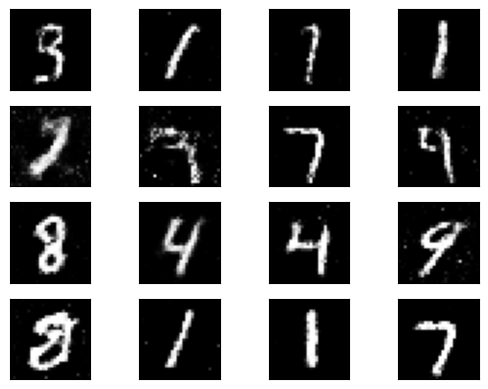

In [9]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

## Improvements DCGAN
We can improve our models by using Conv layers

In [177]:
class DiscriminatorCNN(nn.Module):
    def __init__(self, channels=1, num_of_feature_maps=64):
        super().__init__()
        self.model = nn.Sequential(
           # input is (channels) x 64 x 64
            nn.Conv2d(channels, num_of_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (num_of_feature_maps) x 32 x 32
            nn.Conv2d(num_of_feature_maps, num_of_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (num_of_feature_maps * 2) x 16 x 16
            nn.Conv2d(num_of_feature_maps * 2, num_of_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (num_of_feature_maps * 4) x 8 x 8
            nn.Conv2d(num_of_feature_maps * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output.view(-1, 1).squeeze(1)

class GeneratorCNN(nn.Module):
    def __init__(self, latent_vector_size=100, num_of_feature_maps=64, channels=1):
        super().__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, num_of_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 8),
            nn.ReLU(True),
            
            # state size. (num_of_feature_maps * 8) x 4 x 4
            nn.ConvTranspose2d(num_of_feature_maps * 8, num_of_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 4),
            nn.ReLU(True),
            
            # state size. (num_of_feature_maps * 4) x 8 x 8
            nn.ConvTranspose2d(num_of_feature_maps * 4, num_of_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 2),
            nn.ReLU(True),
            
            # state size. (num_of_feature_maps * 2) x 16 x 16
            nn.ConvTranspose2d(num_of_feature_maps * 2, num_of_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(num_of_feature_maps, channels, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        #x = x.view(x.size(0), latent_vector_size)
        return self.model(x)



discriminator = DiscriminatorCNN().to(device=device)
generator = GeneratorCNN().to(device=device)

print(discriminator)

DiscriminatorCNN(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [178]:
def train_dcgan(discriminator, generator, train_loader, epochs, gen_optimizer, disc_optimizer, loss_function):
    real_label = 1.
    fake_label = 0.
    latent_vector_size = 100
    
    for epoch in tqdm(range(epochs), desc="Total train progress", position=0):
        for n, (samples, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}', position=1, leave=False), 0):
        
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            discriminator.zero_grad()
            real_cpu = samples.to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label, device=device)

            output = discriminator(real_cpu)
            errD_real = loss_function(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
            fake = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_fake = loss_function(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            disc_optimizer.step()
        
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            label.fill_(real_label) 
            output = discriminator(fake)
            errG = loss_function(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            gen_optimizer.step()

        print(f'Epoch: {epoch}, Loss_D: {errD.item()} Loss_G: {errG.item()}')             
        torch.save(generator.state_dict(), './weights/netG_epoch_%d.pth' % (epoch))
        torch.save(discriminator.state_dict(), './weights/netD_epoch_%d.pth' % (epoch))

In [179]:
lr = 0.0001
epochs = 50
loss_function = nn.BCELoss() #nn.BCEWithLogitsLoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [180]:
train_dcgan(discriminator, generator, train_loader, epochs, optimizer_generator, optimizer_discriminator, loss_function)

Total train progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 0, Loss_D: 1.3742389455728699e-05 Loss_G: 11.680200576782227


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1, Loss_D: 4.59085640613921e-06 Loss_G: 12.584037780761719


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2, Loss_D: 0.9524461627006531 Loss_G: 1.0954453945159912


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3, Loss_D: 1.1363215446472168 Loss_G: 1.1943998336791992


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4, Loss_D: 1.0016940832138062 Loss_G: 1.30936598777771


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5, Loss_D: 1.224246621131897 Loss_G: 0.9931572675704956


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6, Loss_D: 1.155644416809082 Loss_G: 1.160842776298523


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7, Loss_D: 0.9852477312088013 Loss_G: 1.2136847972869873


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8, Loss_D: 1.1012946367263794 Loss_G: 1.243664026260376


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9, Loss_D: 0.9594389796257019 Loss_G: 1.5142638683319092


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10, Loss_D: 0.7870806455612183 Loss_G: 1.4167191982269287


Epoch 12:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 11, Loss_D: 1.1992533206939697 Loss_G: 1.230135440826416


Epoch 13:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 12, Loss_D: 1.1083210706710815 Loss_G: 1.3695539236068726


Epoch 14:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 13, Loss_D: 0.9304726719856262 Loss_G: 1.3033883571624756


Epoch 15:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 14, Loss_D: 0.8538075089454651 Loss_G: 1.678196907043457


Epoch 16:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 15, Loss_D: 0.7618132829666138 Loss_G: 1.9571821689605713


Epoch 17:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 16, Loss_D: 0.8187105655670166 Loss_G: 1.6772246360778809


Epoch 18:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 17, Loss_D: 0.8571516275405884 Loss_G: 1.7624801397323608


Epoch 19:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 18, Loss_D: 1.389080286026001 Loss_G: 2.285214900970459


Epoch 20:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 19, Loss_D: 0.775039792060852 Loss_G: 1.883324146270752


Epoch 21:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 20, Loss_D: 0.9878575205802917 Loss_G: 1.947814702987671


Epoch 22:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 21, Loss_D: 0.8166388273239136 Loss_G: 1.6134568452835083


Epoch 23:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 22, Loss_D: 0.5288301706314087 Loss_G: 2.0837268829345703


Epoch 24:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 23, Loss_D: 0.817915678024292 Loss_G: 1.497413158416748


Epoch 25:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 24, Loss_D: 0.5420748591423035 Loss_G: 2.4457058906555176


Epoch 26:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 25, Loss_D: 0.6238608956336975 Loss_G: 2.3004698753356934


Epoch 27:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 26, Loss_D: 0.8844184279441833 Loss_G: 1.7004928588867188


Epoch 28:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 27, Loss_D: 0.7094966769218445 Loss_G: 1.4769673347473145


Epoch 29:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 28, Loss_D: 0.435490220785141 Loss_G: 2.1143927574157715


Epoch 30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 29, Loss_D: 0.4798259437084198 Loss_G: 2.5178089141845703


Epoch 31:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 30, Loss_D: 1.491856336593628 Loss_G: 3.168055534362793


Epoch 32:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 31, Loss_D: 0.5097383260726929 Loss_G: 1.8865662813186646


Epoch 33:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 32, Loss_D: 0.8506481051445007 Loss_G: 1.6577117443084717


Epoch 34:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 33, Loss_D: 0.7394407391548157 Loss_G: 1.886938452720642


Epoch 35:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 34, Loss_D: 0.4984181821346283 Loss_G: 2.4974470138549805


Epoch 36:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 35, Loss_D: 0.6900476813316345 Loss_G: 2.2430593967437744


Epoch 37:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 36, Loss_D: 0.44284698367118835 Loss_G: 2.464951276779175


Epoch 38:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 37, Loss_D: 0.5780963897705078 Loss_G: 2.3207788467407227


Epoch 39:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 38, Loss_D: 0.9376815557479858 Loss_G: 1.6121025085449219


Epoch 40:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 39, Loss_D: 0.4431079030036926 Loss_G: 2.816857099533081


Epoch 41:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 40, Loss_D: 0.6549743413925171 Loss_G: 2.571272134780884


Epoch 42:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 41, Loss_D: 0.9591141939163208 Loss_G: 1.8849358558654785


Epoch 43:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 42, Loss_D: 0.3253558278083801 Loss_G: 2.522160530090332


Epoch 44:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 43, Loss_D: 0.681350588798523 Loss_G: 2.4943957328796387


Epoch 45:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 44, Loss_D: 0.7372713088989258 Loss_G: 2.130871295928955


Epoch 46:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 45, Loss_D: 0.5064111351966858 Loss_G: 1.891336441040039


Epoch 47:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 46, Loss_D: 0.7161550521850586 Loss_G: 2.40207576751709


Epoch 48:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 47, Loss_D: 0.569851815700531 Loss_G: 2.4913783073425293


Epoch 49:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 48, Loss_D: 0.47502708435058594 Loss_G: 2.6228315830230713


Epoch 50:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 49, Loss_D: 0.6020854115486145 Loss_G: 2.4950509071350098


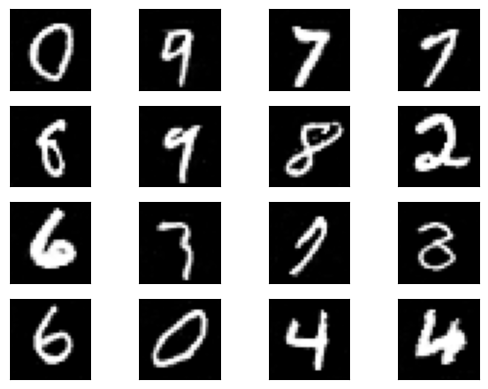

In [181]:
latent_space_samples = torch.randn(batch_size, 100, 1, 1, device=device)

generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])